<center><img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/></center>

# Practicum Project: Tower Research NY

## Cross-exchange Pricing Anomaly Detection for Crypto Market ##

* Yu-Ching Liao <ycliao3@illinois.edu>

## Basic Import

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
import numpy as np


warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from time import sleep
from tqdm import tqdm, trange
import pandas as pd
import requests
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from matplotlib.animation import FuncAnimation,PillowWriter
from collections import deque

import timeit
import logging
import sys
import datetime

## Defination

### Log. 

In [2]:
def setup_logger():
    logger = logging.getLogger('my_logger')
    logger.setLevel(logging.INFO)

    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(message)s')
    handler.setFormatter(formatter)

    file_handler = logging.FileHandler('logfile.log')
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)

    logger.handlers.clear()

    logger.addHandler(handler)
    logger.addHandler(file_handler)
    return logger

def disable_logging(logger):
    logger.setLevel(logging.CRITICAL)

def enable_logging(logger):
    logger.setLevel(logging.INFO)

In [3]:
# setup logger
logger = setup_logger()
disable_logging(logger)

In [4]:
# create enum type
from enum import Enum
class VarCheckType(Enum):
    MA = "moving_average"
    
    MEAN_STD = "mean_std"
    OTHER = "other" 

In [5]:
# using API
def fetch_stock_data(ticker, exchange_name, timestamp, prev_value): # will replace the data with previous if status code is not 200
    url = 'http://localhost:8080/exchangeData'
    query_params = {
        "exchangeName": exchange_name,
        "symbol": ticker,
        "time": timestamp
    }
    response = requests.get(url, params=query_params)
    stock_data = {'askpx': prev_value if prev_value != 0 else np.nan} # will return nan if there is no prev price
    if response.status_code == 200:
        #print("Request successful!")
        logger.info(f' Request to exchange {exchange_name} is successful')
        stock_data = response.json()['data']
    else:
        logger.warn(f' Request to exchange {exchange_name} failed with status code {response} using previous value')

    return stock_data

def fetch_date(ticker):
    url = 'http://localhost:8080/pairDates'
    query_params = {
        "symbol": ticker,
    }
    response = requests.get(url, params=query_params)
    time_list = []
    if response.status_code == 200:
        print("Request successful!")
        time_list = response.json()['time_list']
    else:
        print(f"Request failed with status code {response}")
    return time_list

def fetch_exchanges(exchanges, ticker, timestamp ,pre_vals):
    with ThreadPoolExecutor(max_workers=len(exchanges)) as executor:
        futures = {executor.submit(fetch_stock_data, ticker, exchange_name, timestamp, pre_vals.get(exchange_name,np.nan)): exchange_name for exchange_name in exchanges}
        results = {}
        for future in as_completed(futures):
            exchange_name = futures[future]
            try:
                result = future.result()
                results[exchange_name] = result
            except Exception as e:
                print(f"Error: {e}")
    return results

def fourier_weight_amplifier(weights): # O(Nlog(N))
    if len(weights) == 0:
        return weights
    # Apply the Fourier transform to the signal
    else:
        fourier_coeffs = np.fft.fft(weights) 

        # Amplify the signal by multiplying the Fourier coefficients by a constant greater than 1
        amplification_factor = np.pi
        amplified_fourier_coeffs = fourier_coeffs * amplification_factor

        # Apply the inverse Fourier transform to obtain the amplified signal
        amplified_signal = np.fft.ifft(amplified_fourier_coeffs)
        
        return amplified_signal.real

### Best Parameter Seeker

In [6]:
def get_best_parameter(best_parameters_path, ticker):
    best_parameters = pd.read_csv(best_parameters_path)
    if ticker.replace('/', '_') in list(best_parameters['Name']):
        return int(best_parameters[best_parameters['Name'] == ticker.replace('/', '_')]['Scoring Mins'].values[0])
    else: 
        print("No Best Parameter for", ticker, "tested.")
        print("Please tested the parameter for this pair or check your input. ")
        return 0

In [7]:
class Anomaly(Enum):
    # Qoute anomailes
    MISSING_QOUTE = "Missing Qoute"
    ASK_STALE_QOUTE = "Ask Stale Qoute"
    BID_STALE_QOUTE = "Bid Stale Qoute"
    NON_CONTINUOUS_QOUTE = 'Non Continuous Qoute'
    # Price Anomailes
    NOT_ENOUGH_EXCHANGE_DATA = 'Not Enough Exchanges Data'
    ABNORMAL_PRICE_SPIKE = "Abnormal Price Spike"

    # Anomailes spread
    NEGATIVE_SPREAD = "Negative Spread"

    # Vol Anomailes
    ABNORMAL_VOL_SPIKE = "Abnormal Volume Spike"
    VOL_ZERO_OR_NEGATIVE = "Bid Volume Zero/Negative"



class AnomalyLv(Enum):
    DEFAULT_LV = 0
    WARNING_LV = 1
    CRITICAL_LV = 2
    

### Main Algorithm

In [9]:
def cluster_pricing_tester(ticker, n_scoring_window, use_varcheck, var_path, exchanges, use_api, file_path,var_check_window = 60, use_anomalies_detection = False, anomalies_args= [2,1,1]):

    # Anomalies detection variable
    pre_vals = {} # store prev price for all exchange
    stale_qoute_window = 10 # have to change this to user defined config
    prev_qoutes = {}
    volatility_window = deque(maxlen=30) # for calcualte moving voltality 

    # Variance Check variable
    std_ma_window_s = deque(maxlen = var_check_window)
    std_ma_window_l = deque(maxlen = var_check_window*12)
    

    # Clustering variable
    scoring_window = deque(maxlen=n_scoring_window)
    hq_exchange_scoring = {exchange_name: 0 for exchange_name in exchanges}
    lq_exchange_scoring = {exchange_name: 0 for exchange_name in exchanges}
    index_prices = []

    # Internal variable
    exchanges_data = {}
    time_list = []
    hq_lq_tuple = tuple()

    # testing variable
    start_date_index = -1
    date_index_for_testing = []
    # function will update exchange_scoring
    def update_exchange_scoring(hq_lq_tuple, updated_score):
            for hq_exchange in hq_lq_tuple[0]:
                hq_exchange_scoring[hq_exchange] += updated_score
            for lq_exchange in hq_lq_tuple[1]:
                lq_exchange_scoring[lq_exchange] += updated_score

    
    
    # sending api to get date first

    # check if not using api will load data from csv
    if use_api:
        time_list = fetch_date(ticker)
    else:    
        exchanges_data_df = pd.read_csv(file_path+ticker.replace('/','_')+'.csv',index_col='time')
        exchanges_data_dict = exchanges_data_df.to_dict(orient='index')
        time_list = exchanges_data_df.index
    
    def simulate_incomming_exchange_data(curr_date):
        # for dataframe testing
        exchanges_details_col = ['askpx','bidpx','askqty','bidqty']
        exchange_data = {}
        for exchange_name in exchanges:
            exchange_details = {}
            for col in exchanges_details_col:
                tmp_exchange_detail = exchanges_data_dict[curr_date][exchange_name + "_"+col]
                if np.isnan(tmp_exchange_detail):
                    continue
                exchange_details[col] = tmp_exchange_detail
            exchange_data[exchange_name] = exchange_details
        return exchange_data

    # iterate throught the time_list 
    for date_indx in tqdm(range(len(time_list))):
        curr_date = time_list[date_indx]
        if use_api:
            # Measure api response time
            api_response_time_start = timeit.default_timer()

            # get data of each exchanges in dictionary
            exchanges_data = fetch_exchanges(exchanges,ticker,curr_date,pre_vals)
            api_response_time_end = timeit.default_timer()
    
            # write response time to the logger
            logger.info(f'requested params: date: {curr_date} and pairs: {ticker} : API Response time: {api_response_time_end-api_response_time_start:.4f} seconds')
            exchanges_prices = {exchange_name: exchanges_data.get(exchange_name,np.nan).get('askpx',np.nan) for exchange_name in exchanges}
            
        else:
            # reading from CSV here must be aggregrate file with price and vol data for anomailes detection
            exchanges_data = simulate_incomming_exchange_data(curr_date)
            exchanges_prices = {exchange_name: exchanges_data_dict[curr_date][exchange_name + "_askpx"] for exchange_name in exchanges} # <- have to change this any only use the prices that was not have critical anomaly

        # variable for anomailes detection
        exchange_anomailes_detection = {exchange_name: {'anomailes_lv': AnomalyLv.DEFAULT_LV.value ,'anomailes_occured':list()} for exchange_name in exchanges}

        # create anomalies detecation function to check data 
        def anomalies_detections(exchanges_data):
            '''
            This function will populate exchange_anomailes_detection dict to return all
            the anomailes found in each exchanges including our index prices.
            '''

            def detect_stale_quote(exchange_name,price_type, price):
                '''
                Will detect stale qoute of bid or ask prices using type to identify if it bidpx or askpx
                '''
                if np.isnan(price): return False
                if exchange_name not in prev_qoutes:
                    # If the exchange is not in the dictionary, add it with the current quote using deque will discard the oldest one
                    prev_qoutes[exchange_name] = {}
                    prev_qoutes[exchange_name][price_type] = deque([price],maxlen=stale_qoute_window)
                else:
                    if price_type not in prev_qoutes[exchange_name]: prev_qoutes[exchange_name][price_type] = deque(maxlen=stale_qoute_window)
                    prev_qoutes[exchange_name][price_type].append(price)

                    # Check if the current quote is the same as the previous N-1 quotes
                    if len(prev_qoutes[exchange_name][price_type]) == stale_qoute_window and all(quote == prev_qoutes[exchange_name][price_type][-1] for quote in prev_qoutes[exchange_name][price_type]):
                        return True  # Stale quote detected

                return False  # Quote is not stale
            
            def update_anomailes_lv(exchange_name,anomailes_lv):
                exchange_anomailes_detection[exchange_name]['anomailes_lv'] = max(exchange_anomailes_detection[exchange_name]['anomailes_lv'],anomailes_lv)


            for exchange_name, exchange_details in exchanges_data.items():
                # check mising qoute critical
                if not exchange_details:
                    exchange_anomailes_detection[exchange_name]['anomailes_occured'].append(Anomaly.MISSING_QOUTE.value)
                    update_anomailes_lv(exchange_name,AnomalyLv.CRITICAL_LV.value)
                    # update anomailes lv
                    continue

                # check for stale qoute critical
                if detect_stale_quote(exchange_name,'askpx', exchange_details['askpx']):
                    exchange_anomailes_detection[exchange_name]['anomailes_occured'].append(Anomaly.ASK_STALE_QOUTE.value)
                    update_anomailes_lv(exchange_name,AnomalyLv.CRITICAL_LV.value)

                if detect_stale_quote(exchange_name,'bidpx', exchange_details['bidpx']):
                    exchange_anomailes_detection[exchange_name]['anomailes_occured'].append(Anomaly.BID_STALE_QOUTE.value)
                    update_anomailes_lv(exchange_name,AnomalyLv.WARNING_LV.value)

                # check negative spread critical
                spread = exchange_details['askpx'] - exchange_details['bidpx']
                if spread < 0: 
                    exchange_anomailes_detection[exchange_name]['anomailes_occured'].append(Anomaly.NEGATIVE_SPREAD.value)
                    # critical 
                    update_anomailes_lv(exchange_name,AnomalyLv.CRITICAL_LV.value)

                # check if vol < 0 or 0 warning
                curr_vol = exchange_details['bidqty']+exchange_details['askqty']
                if curr_vol <= 0:
                    exchange_anomailes_detection[exchange_name]['anomailes_occured'].append(Anomaly.VOL_ZERO_OR_NEGATIVE.value)
                    update_anomailes_lv(exchange_name,AnomalyLv.WARNING_LV.value)

        def print_current_anomalies(exchange_anomailes_detection):
            print('***************CURRENT ANOMALY START************************')
            for exchange_name, details in exchange_anomailes_detection.items():
                if details['anomailes_lv'] > 0:
                    print(f"Anomailes detected on exchange: {exchange_name}")
                    print(f'Anomaly details: {details}')
            print('***************CURRENT ANOMALY END************************')

        anomalies_detections(exchanges_data)
        # print_current_anomalies(exchange_anomailes_detection)

        pre_vals = exchanges_prices # ** Implement HERE: update on non NaN values in dict
            
        # get price and associate exchanges name in defferent list
        curr_exchange_key = np.array([exchange_name for exchange_name in exchanges if not np.isnan(exchanges_prices[exchange_name])])
        curr_prices = np.array([exchanges_prices[exchange_name] for exchange_name in curr_exchange_key]) # This will garantee the order of the prices

        # # get only prices that have non-critical anomaily
        # curr_exchange_key = []
        # curr_prices = []
        # for exchange_name in exchanges:
        #     if not np.isnan(exchanges_prices[exchange_name]) and exchange_anomailes_detection[exchange_name]['anomailes_lv'] < 2:
        #         curr_exchange_key.append(exchange_name)
        #         curr_prices.append(exchanges_prices[exchange_name])

        # curr_exchange_key = np.array(curr_exchange_key)
        # curr_prices = np.array(curr_prices)
        # # anomailes filtering end

        #check if all nan or not # return some error or warning
        if len(curr_prices) == 0: 
            start_date_index = date_indx
            continue

        #*** Testing
        date_index_for_testing.append(curr_date)


        mean_price = np.median(curr_prices)
        distances_from_mean = abs(curr_prices - mean_price)
                    
        # IMPLEMENT VAR CHECK HERE
        def var_checking(use_varcheck,curr_prices):
            '''
            This function will return True when there are high voltility in the market.
            it will compare current market data to prevrious std_ma_window of std MA
            '''
            if not use_varcheck: return True

            def update_std_moving_window(curr_std):
                # deprecate using deque will auto remove
                # while(len(std_ma_window) +1 > var_check_window):
                #     std_ma_window.popleft()
                std_ma_window_l.append(curr_std)
                std_ma_window_s.append(curr_std)

            curr_std = np.std(curr_prices)
            if curr_std > np.mean(std_ma_window_s) or curr_std >= std_ma_window_l:
                update_std_moving_window(curr_std)
                return True
            return False
            

        # END 

        # find exchange name that is not abnormal
        curr_normal_exchange_key = np.array([exchange_name for exchange_name in exchanges 
                            if not np.isnan(exchanges_prices[exchange_name]) 
                            and exchange_anomailes_detection[exchange_name]['anomailes_lv'] < 2])
        # anomailes filtering end
        # intialize hq_lq_tuple default value with non abnomailes excahnge prices in case that our model wont get clusterd
        hq_lq_tuple = (curr_normal_exchange_key if len(curr_normal_exchange_key)>0 else curr_exchange_key, []) 
        
        #print("Is we using cluster: ",len(curr_prices) > 1 and var_checking(use_varcheck,curr_prices,var_check_abs_threshold))


        # Check if there are more than 1 exhcanges prices and check variance
        if len(curr_prices) > 1 and var_checking(use_varcheck,curr_prices):
            clustering_timer_start = timeit.default_timer()

            distances_from_mean = distances_from_mean.reshape(-1, 1)        
            distance_matrix = euclidean_distances(distances_from_mean, distances_from_mean)

            kmeans = KMeans(n_clusters=2)
            pipeline = make_pipeline(Normalizer(), kmeans)
            pipeline.fit(distance_matrix)
            clustering_label = np.array(pipeline.predict(distance_matrix))

            clustering_timer_end = timeit.default_timer()
            logger.info(f' Clustering time:  {clustering_timer_end - clustering_timer_start:.4f} seconds')

           

            # check if ther only 1 clustering label so we use all the exchange anyways
            #print("is there are more than 1 cluster label: ",len(set(clustering_label)) > 1)
            if len(set(clustering_label)) > 1:
                cluster_means = np.array([np.mean(curr_prices[clustering_label == i]) for i in range(2)])
                min_distance_index = np.argmin(np.abs(cluster_means - mean_price))
                # if len(curr_exchange_key[clustering_label == min_distance_index]) > 0:
                hq_lq_tuple = (curr_exchange_key[clustering_label == min_distance_index],
                                curr_exchange_key[clustering_label != min_distance_index])
                #print("hq_lq_tuple ",hq_lq_tuple)
        

            logger.info(f' HQ Exchanges :  {hq_lq_tuple[0]} LQ Exchanges : {hq_lq_tuple[1]}')

            # check if overflow the scoring windows
            while len(scoring_window) + 1 > n_scoring_window:
                # pop left scoring window
                prev_hq_lq = scoring_window.popleft()
                # remove previous scoring
                update_exchange_scoring(prev_hq_lq,-1)# O(Nlog(N))

            # append scoring window
            update_exchange_scoring(hq_lq_tuple,1)
            scoring_window.append(hq_lq_tuple)
            

            # calculate weight for each of curr_exchange
            curr_weights =  np.array([hq_exchange_scoring[exchange_name]/(lq_exchange_scoring[exchange_name]+hq_exchange_scoring[exchange_name]) for exchange_name in hq_lq_tuple[0]])       
            hq_prices = np.array([exchanges_prices[exchange_name] for exchange_name in hq_lq_tuple[0]])
            logger.info(f' Weight(using only HQ Prices):  {curr_weights}')

            
            # amplified the weight using fourier amplifier
            curr_weights = fourier_weight_amplifier(curr_weights)
            logger.info(f' Amplified Weight(using only HQ Prices):  {curr_weights}')
            curr_index_prices = np.dot(hq_prices, curr_weights) / np.sum(curr_weights)
            # calculate index price using amplified weight and hq prices
        else:
            # check if overflow the scoring windows
            while len(scoring_window) + 1 > n_scoring_window:
                # pop left scoring window
                prev_hq_lq = scoring_window.popleft()
                # remove previous scoring
                update_exchange_scoring(prev_hq_lq,-1)# O(Nlog(N))

            # append scoring window
            update_exchange_scoring(hq_lq_tuple,1)
            scoring_window.append(hq_lq_tuple)
            curr_index_prices = mean_price
        
        index_prices.append(curr_index_prices)
        logger.info(f' Index Prices :  {curr_index_prices}')
        logger.info(f' Mean Prices :  {mean_price}')
        if np.isnan(curr_index_prices):
            print(f"This index prices {curr_index_prices} is NaN")
            print("hq_lq_tuple ",hq_lq_tuple)
            print(f'curr_dates: {curr_date} curr prices: {curr_prices}')
            print(f'curr_normal_exchange_key : {curr_normal_exchange_key}')
            print(f'exchange_anomailes_detection :',exchange_anomailes_detection)
     
    return index_prices, date_index_for_testing
testing_exchanges = ['8', '9', '10', '12', '16', '19', '25', '28', '30']

### Result Outputting

In [10]:
def Delete_all_PNG(i):
    pngfiles = [f for f in os.listdir(i) if f.endswith(".png")]
    print("existing png files: " + str(pngfiles))
    [os.remove(i + f) for f in pngfiles]
    print("All photo removed.")
    print("------------------------------------------------------")

def Delete_all_CSV(i):
    pngfiles = [f for f in os.listdir(i) if f.endswith(".csv")]
    print("existing png files: " + str(pngfiles))
    [os.remove(i + f) for f in pngfiles]
    print("All csv removed.")
    print("------------------------------------------------------")


def saver(fname):
    plt.savefig(fname + ".png", bbox_inches="tight")

def generate_result(ticker, n_scoring_window, index_price, exchanges_data_df, font_size, start_date, mon):
    #Kill Previous Result

    median_price_path  = median_path(ticker, exchanges_data_df, start_date)

    target = exchanges_data_df['1_askpx']
    target = target[start_date]

    # First Generate Plot
    r2 = R2(index_price,target)
    mse = MSE(index_price,target)
    mape = MAPE(index_price,target )

    # First Generate Plot
    med_r2 = R2(median_price_path,target)
    med_mse = MSE(median_price_path,target)
    med_mape = MAPE(median_price_path,target)

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(target.index, median_price_path, color='red', label = ticker+" Median Prices")
    ax.plot(target.index, target, color="blue", label = 'Target Prices')
    ax.plot(target.index, index_price, color='orange', label = ticker+" Index Prices")



    ax.set_title(mon+"_" + ticker+",  Best Scoring Mins: "+str(n_scoring_window))
    ax.set_ylabel(ticker+" Prices")
    ax.set_xlabel("Date")

    table_data = [["R square", r2,  med_r2], ["MSE", mse, med_mse], ["MAPE", mape, med_mape]]
    table = ax.table(cellText=table_data, 
                    cellLoc = "center",
                    colWidths=[0.5, 0.75, 0.75], 
                    colLabels=['Index', 'Result', "Result of Median"], 
                    loc="center", 
                    bbox=[0, -0.5, 1, 0.3])
    table.set_fontsize(font_size)

    # Place the legend outside the plot to the right
    ax.legend()

    saver(path_out3 + ticker.replace("/", "_") + "_S" +
        str(n_scoring_window))

    plt.close()

    #Second Generate Pathes
    export = {
        ticker+", Best Scoring Mins: "+str(n_scoring_window): index_price,
        "Median Pathes": median_price_path, 
        "1.csv": target
    }
    export = pd.DataFrame(export, index=target.index)
    export.to_csv(path_out2+mon+"_" +ticker.replace("/", "_")+"_HQ_Prices_Pathes.csv")

    #Third Generate Accuracy
    export2 = {
        ticker+", Best Scoring Mins: "+str(n_scoring_window): [r2, mse, mape], 
        "Median Pathes": [med_r2, med_mse, med_mape]
    }
    export2 = pd.DataFrame(export2, index=["R square", "MSE", "MAPE"])
    export2.to_csv(path_out1+mon+"_"  + ticker.replace("/", "_")+"_HQ_Prices_Outcome.csv")
    display(export2.transpose())

    return [r2, med_r2], [mse, med_mse], [mape, med_mape]

def median_path(ticker, exchanges_data_df, start_date):
    l = ['8_askpx', '9_askpx', '10_askpx', '12_askpx', '16_askpx', '19_askpx', '25_askpx', '28_askpx', '30_askpx']
    index_price = exchanges_data_df[l].fillna(method='ffill').median(axis = 1)
    index_price = index_price[start_date]

    return index_price


## Run

### !!!Read Instruction!!! ###
Before run this code, modify the path that the "aggre_csv" located as "input_path", </br>
modify the path that the "Best Parameters.csv" located as "best_parameters_path", </br>
also create three folders for output. </br></br>
path_out1 will store the accracies (R2, MSE and MAPE). </br>
path_out2 will store the pathes. </br>
path_out3 will store the plot of our model. </br>
and best_parameters_path should store the csv file "Best Parameters.csv"</br></br>

Make sure that you have store the output you want to other folders since the program will kill all the outputs in each run. 

In [11]:
best_parameters_path = "Best Patameters.csv"
best_parameters = pd.read_csv(best_parameters_path)
test = sorted(list(set(list(best_parameters['Name'].values))))

In [12]:
print(test)

['AAVE_BTC', 'AAVE_ETH', 'ADA_BTC', 'ADA_ETH', 'ALGO_BTC', 'ANT_BTC', 'ATOM_BTC', 'ATOM_ETH', 'AVAX_BTC', 'BAT_BTC', 'BCH_BTC', 'BNT_BTC', 'BTC_EUR', 'COMP_BTC', 'CRV_BTC', 'CRV_ETH', 'DASH_BTC', 'DCR_BTC', 'DOGE_BTC', 'DOT_BTC', 'ENJ_BTC', 'EOS_BTC', 'EOS_ETH', 'ETC_BTC', 'ETC_ETH', 'ETH_BTC', 'FIL_BTC', 'FIL_ETH', 'GRT_BTC', 'ICX_BTC', 'IOST_BTC', 'IOTA_BTC', 'KNC1_BTC', 'LINK_BTC', 'LINK_ETH', 'LRC_BTC', 'LSK_BTC', 'LTC_BTC', 'MANA_BTC', 'MANA_ETH', 'MATIC_BTC', 'MKR_BTC', 'NEO_BTC', 'OMG_BTC', 'QTUM_BTC', 'QTUM_ETH', 'REN_BTC', 'SNT_BTC', 'SOL_BTC', 'SRM_BTC', 'SUSHI_BTC', 'TRX_BTC', 'TRX_ETH', 'UNI_BTC', 'UNI_ETH', 'WAVES_BTC', 'WBTC_BTC', 'XEM_BTC', 'XLM_BTC', 'XLM_ETH', 'XRP_BTC', 'XRP_ETH', 'XTZ_BTC', 'XTZ_ETH', 'YFI_BTC', 'ZEC_BTC', 'ZIL_BTC', 'ZRX_BTC']


existing png files: ['October_CRV_ETH_HQ_Prices_Outcome.csv', 'October_BTC_EUR_HQ_Prices_Outcome.csv', 'October_AAVE_BTC_HQ_Prices_Outcome.csv', 'October_ANT_BTC_HQ_Prices_Outcome.csv', 'October_ADA_ETH_HQ_Prices_Outcome.csv', 'October_ATOM_BTC_HQ_Prices_Outcome.csv', 'October_COMP_BTC_HQ_Prices_Outcome.csv', 'October_BAT_BTC_HQ_Prices_Outcome.csv', 'October_BCH_BTC_HQ_Prices_Outcome.csv', 'October_ADA_BTC_HQ_Prices_Outcome.csv', 'October_ATOM_ETH_HQ_Prices_Outcome.csv', 'October_ALGO_BTC_HQ_Prices_Outcome.csv', 'October_BNT_BTC_HQ_Prices_Outcome.csv', 'October_AAVE_ETH_HQ_Prices_Outcome.csv', 'October_CRV_BTC_HQ_Prices_Outcome.csv', 'October_DASH_BTC_HQ_Prices_Outcome.csv', 'October_AVAX_BTC_HQ_Prices_Outcome.csv']
All csv removed.
------------------------------------------------------
existing png files: ['October_COMP_BTC_HQ_Prices_Pathes.csv', 'October_CRV_BTC_HQ_Prices_Pathes.csv', 'October_ANT_BTC_HQ_Prices_Pathes.csv', 'October_AAVE_BTC_HQ_Prices_Pathes.csv', 'October_ADA_BTC_HQ

100%|██████████| 11508/11508 [00:00<00:00, 12899.16it/s]


,R square,MSE,MAPE
"AAVE_BTC, Best Scoring Mins: 8000",0.998503,1.082149e-11,0.000768
Median Pathes,0.998351,1.191735e-11,0.000818


0.014705882352941176
Now Testing: AAVE_ETH


100%|██████████| 11335/11335 [00:00<00:00, 11646.90it/s]


,R square,MSE,MAPE
"AAVE_ETH, Best Scoring Mins: 8000",0.952593,4.805119e-08,0.000714
Median Pathes,0.952684,4.798725e-08,0.000723


0.014705882352941176
Now Testing: ADA_BTC


100%|██████████| 11512/11512 [00:00<00:00, 12055.75it/s]


,R square,MSE,MAPE
"ADA_BTC, Best Scoring Mins: 8000",0.999897,8.881999e-17,0.000370
Median Pathes,0.999883,1.001013e-16,0.000401


0.029411764705882353
Now Testing: ADA_ETH


100%|██████████| 11508/11508 [00:00<00:00, 12095.51it/s]


,R square,MSE,MAPE
"ADA_ETH, Best Scoring Mins: 1000",0.997951,3.098676e-13,0.001583
Median Pathes,0.997944,3.107281e-13,0.001581


0.04411764705882353
Now Testing: ALGO_BTC


100%|██████████| 11508/11508 [00:00<00:00, 11857.76it/s]


,R square,MSE,MAPE
"ALGO_BTC, Best Scoring Mins: 1000",0.994622,1.112315e-15,0.001659
Median Pathes,0.994709,1.095249e-15,0.001686


0.04411764705882353
Now Testing: ANT_BTC


100%|██████████| 11505/11505 [00:00<00:00, 11984.37it/s]


,R square,MSE,MAPE
"ANT_BTC, Best Scoring Mins: 500",0.998886,5.184744e-15,0.000687
Median Pathes,0.998879,5.216019e-15,0.000691


0.058823529411764705
Now Testing: ATOM_BTC


100%|██████████| 11507/11507 [00:00<00:00, 12217.36it/s]


,R square,MSE,MAPE
"ATOM_BTC, Best Scoring Mins: 8000",0.999929,5.987915e-14,0.000324
Median Pathes,0.999926,6.244758e-14,0.000335


0.07352941176470588
Now Testing: ATOM_ETH


100%|██████████| 11512/11512 [00:00<00:00, 13408.60it/s]


,R square,MSE,MAPE
"ATOM_ETH, Best Scoring Mins: 8000",0.999846,2.281594e-11,0.000315
Median Pathes,0.999847,2.258881e-11,0.000312


0.08823529411764706
Now Testing: AVAX_BTC


100%|██████████| 11511/11511 [00:00<00:00, 12705.59it/s]


,R square,MSE,MAPE
"AVAX_BTC, Best Scoring Mins: 1000",0.999130,3.960056e-13,0.000682
Median Pathes,0.999113,4.034165e-13,0.000687


0.10294117647058823
Now Testing: BAT_BTC


100%|██████████| 11512/11512 [00:00<00:00, 11958.38it/s]


,R square,MSE,MAPE
"BAT_BTC, Best Scoring Mins: 8000",0.996745,2.680638e-16,0.000931
Median Pathes,0.996892,2.558960e-16,0.000910


0.10294117647058823
Now Testing: BCH_BTC


100%|██████████| 11509/11509 [00:01<00:00, 11142.98it/s]


,R square,MSE,MAPE
"BCH_BTC, Best Scoring Mins: 1000",0.999437,1.277819e-11,0.000322
Median Pathes,0.999437,1.277423e-11,0.000326


0.11764705882352941
Now Testing: BNT_BTC


100%|██████████| 11511/11511 [00:00<00:00, 12477.14it/s]


,R square,MSE,MAPE
"BNT_BTC, Best Scoring Mins: 1000",0.839970,2.650544e-14,0.005568
Median Pathes,0.801892,3.418989e-14,0.006762


0.1323529411764706
Now Testing: BTC_EUR


100%|██████████| 11512/11512 [00:00<00:00, 13059.50it/s]


,R square,MSE,MAPE
"BTC_EUR, Best Scoring Mins: 8000",0.994829,342.093783,0.000624
Median Pathes,0.996047,261.188463,0.000642


0.1323529411764706
Now Testing: COMP_BTC


100%|██████████| 11507/11507 [00:00<00:00, 12627.92it/s]


,R square,MSE,MAPE
"COMP_BTC, Best Scoring Mins: 1000",0.999287,4.406959e-12,0.000559
Median Pathes,0.999263,4.555817e-12,0.000568


0.14705882352941177
Now Testing: CRV_BTC


100%|██████████| 11507/11507 [00:01<00:00, 10650.14it/s]


,R square,MSE,MAPE
"CRV_BTC, Best Scoring Mins: 8000",0.996965,8.345038e-15,0.001943
Median Pathes,0.996851,8.655442e-15,0.001978


0.16176470588235295
Now Testing: CRV_ETH


100%|██████████| 10885/10885 [00:00<00:00, 12173.13it/s]


,R square,MSE,MAPE
"CRV_ETH, Best Scoring Mins: 5000",0.998247,7.972092e-13,0.001051
Median Pathes,0.998267,7.874112e-13,0.001060


0.16176470588235295
Now Testing: DASH_BTC


100%|██████████| 11512/11512 [00:00<00:00, 13296.74it/s]


,R square,MSE,MAPE
"DASH_BTC, Best Scoring Mins: 8000",0.996406,7.200661e-12,0.000870
Median Pathes,0.995970,8.098857e-12,0.000935


0.17647058823529413
Now Testing: DCR_BTC


100%|██████████| 11505/11505 [00:00<00:00, 12864.63it/s]


,R square,MSE,MAPE
"DCR_BTC, Best Scoring Mins: 1",0.768333,8.400610e-11,0.004708
Median Pathes,0.852428,4.805435e-11,0.004642


0.17647058823529413
Now Testing: DOGE_BTC


100%|██████████| 11509/11509 [00:01<00:00, 10584.54it/s]


,R square,MSE,MAPE
"DOGE_BTC, Best Scoring Mins: 1000",0.998300,4.116040e-18,0.000221
Median Pathes,0.998287,4.147233e-18,0.000228


0.19117647058823528
Now Testing: DOT_BTC


100%|██████████| 11507/11507 [00:00<00:00, 12631.48it/s]


,R square,MSE,MAPE
"DOT_BTC, Best Scoring Mins: 8000",0.999185,2.325919e-14,0.000414
Median Pathes,0.999191,2.310680e-14,0.000413


0.20588235294117646
Now Testing: ENJ_BTC


100%|██████████| 11512/11512 [00:00<00:00, 12562.78it/s]


,R square,MSE,MAPE
"ENJ_BTC, Best Scoring Mins: 1000",0.998738,3.436957e-16,0.000651
Median Pathes,0.998713,3.500087e-16,0.000643


0.22058823529411764
Now Testing: EOS_BTC


100%|██████████| 11512/11512 [00:00<00:00, 11737.63it/s]


,R square,MSE,MAPE
"EOS_BTC, Best Scoring Mins: 500",0.999635,1.758359e-15,0.000449
Median Pathes,0.999621,1.826766e-15,0.000455


0.23529411764705882
Now Testing: EOS_ETH


100%|██████████| 11506/11506 [00:00<00:00, 12353.09it/s]


,R square,MSE,MAPE
"EOS_ETH, Best Scoring Mins: 1",0.041088,1.830496e-08,0.001011
Median Pathes,0.999527,3.816532e-13,0.000514


0.23529411764705882
Now Testing: ETC_BTC


100%|██████████| 11512/11512 [00:00<00:00, 12627.82it/s]


,R square,MSE,MAPE
"ETC_BTC, Best Scoring Mins: 500",0.999913,5.846496e-13,0.000403
Median Pathes,0.999914,5.806024e-13,0.000401


0.25
Now Testing: ETC_ETH


100%|██████████| 11505/11505 [00:00<00:00, 13001.69it/s]


,R square,MSE,MAPE
"ETC_ETH, Best Scoring Mins: 1000",0.999780,2.708706e-10,0.000669
Median Pathes,0.999765,2.892609e-10,0.000712


0.2647058823529412
Now Testing: ETH_BTC


100%|██████████| 11512/11512 [00:01<00:00, 11390.96it/s]


,R square,MSE,MAPE
"ETH_BTC, Best Scoring Mins: 1000",0.99909,2.079416e-10,0.000183
Median Pathes,0.99907,2.126229e-10,0.000185


0.27941176470588236
Now Testing: FIL_BTC


100%|██████████| 11506/11506 [00:01<00:00, 11302.65it/s]


,R square,MSE,MAPE
"FIL_BTC, Best Scoring Mins: 8000",0.997139,1.107643e-13,0.000913
Median Pathes,0.997040,1.145634e-13,0.000926


0.29411764705882354
Now Testing: FIL_ETH


100%|██████████| 11452/11452 [00:00<00:00, 12123.75it/s]


,R square,MSE,MAPE
"FIL_ETH, Best Scoring Mins: 1000",0.935125,4.092468e-10,0.003182
Median Pathes,0.917058,5.258566e-10,0.003950


0.3088235294117647
Now Testing: GRT_BTC


100%|██████████| 11509/11509 [00:00<00:00, 12847.63it/s]


,R square,MSE,MAPE
"GRT_BTC, Best Scoring Mins: 5000",0.998679,5.483752e-17,0.001135
Median Pathes,0.998596,5.816318e-17,0.001151


0.3235294117647059
Now Testing: ICX_BTC


100%|██████████| 11504/11504 [00:00<00:00, 13136.04it/s]


,R square,MSE,MAPE
"ICX_BTC, Best Scoring Mins: 5000",0.968339,4.846697e-15,0.005038
Median Pathes,0.968657,4.806965e-15,0.005086


0.3235294117647059
Now Testing: IOST_BTC


100%|██████████| 11512/11512 [00:00<00:00, 12240.74it/s]


,R square,MSE,MAPE
"IOST_BTC, Best Scoring Mins: 1",0.785458,1.706567e-17,0.004789
Median Pathes,0.789855,1.656187e-17,0.004755


0.3235294117647059
Now Testing: IOTA_BTC


100%|██████████| 11510/11510 [00:00<00:00, 11850.91it/s]


,R square,MSE,MAPE
"IOTA_BTC, Best Scoring Mins: 8000",0.915672,1.041885e-14,0.006532
Median Pathes,0.918072,1.005697e-14,0.006499


0.3235294117647059
Now Testing: KNC1_BTC


100%|██████████| 11512/11512 [00:00<00:00, 13019.97it/s]


,R square,MSE,MAPE
"KNC1_BTC, Best Scoring Mins: 5000",0.999624,4.394050e-15,0.000996
Median Pathes,0.999612,4.531923e-15,0.001017


0.3382352941176471
Now Testing: LINK_BTC


100%|██████████| 11512/11512 [00:00<00:00, 11888.13it/s]


,R square,MSE,MAPE
"LINK_BTC, Best Scoring Mins: 8000",0.998326,2.108887e-13,0.001133
Median Pathes,0.998334,2.098097e-13,0.001130


0.35294117647058826
Now Testing: LINK_ETH


100%|██████████| 11512/11512 [00:00<00:00, 12394.58it/s]


,R square,MSE,MAPE
"LINK_ETH, Best Scoring Mins: 8000",0.998576,2.795545e-11,0.000846
Median Pathes,0.998581,2.784599e-11,0.000842


0.36764705882352944
Now Testing: LRC_BTC


100%|██████████| 11512/11512 [00:00<00:00, 12581.60it/s]


,R square,MSE,MAPE
"LRC_BTC, Best Scoring Mins: 8000",0.999218,2.747647e-16,0.001084
Median Pathes,0.999200,2.809598e-16,0.001099


0.38235294117647056
Now Testing: LSK_BTC


100%|██████████| 11504/11504 [00:00<00:00, 12795.46it/s]


,R square,MSE,MAPE
"LSK_BTC, Best Scoring Mins: 1000",0.986851,3.942988e-14,0.003282
Median Pathes,0.984329,4.656786e-14,0.003592


0.39705882352941174
Now Testing: LTC_BTC


100%|██████████| 11512/11512 [00:00<00:00, 11574.93it/s]


,R square,MSE,MAPE
"LTC_BTC, Best Scoring Mins: 500",0.998819,1.805327e-12,0.000428
Median Pathes,0.998817,1.808447e-12,0.000427


0.4117647058823529
Now Testing: MANA_BTC


100%|██████████| 11511/11511 [00:00<00:00, 13169.58it/s]


,R square,MSE,MAPE
"MANA_BTC, Best Scoring Mins: 5000",0.999865,1.668144e-16,0.000282
Median Pathes,0.999863,1.687603e-16,0.000282


0.4264705882352941
Now Testing: MANA_ETH


100%|██████████| 11502/11502 [00:00<00:00, 12743.38it/s]


,R square,MSE,MAPE
"MANA_ETH, Best Scoring Mins: 500",0.869012,2.562583e-11,0.000588
Median Pathes,0.868970,2.562555e-11,0.000585


0.4411764705882353
Now Testing: MATIC_BTC


100%|██████████| 11508/11508 [00:00<00:00, 13751.26it/s]


,R square,MSE,MAPE
"MATIC_BTC, Best Scoring Mins: 500",0.998739,1.076492e-15,0.000711
Median Pathes,0.998701,1.108302e-15,0.000721


0.45588235294117646
Now Testing: MKR_BTC


100%|██████████| 11505/11505 [00:00<00:00, 12482.88it/s]


,R square,MSE,MAPE
"MKR_BTC, Best Scoring Mins: 8000",0.999115,6.636113e-09,0.001425
Median Pathes,0.999118,6.618097e-09,0.001427


0.47058823529411764
Now Testing: NEO_BTC


100%|██████████| 11511/11511 [00:00<00:00, 12223.16it/s]


,R square,MSE,MAPE
"NEO_BTC, Best Scoring Mins: 500",0.998209,2.661893e-13,0.000680
Median Pathes,0.998205,2.666807e-13,0.000678


0.4852941176470588
Now Testing: OMG_BTC


100%|██████████| 11512/11512 [00:00<00:00, 12267.77it/s]


,R square,MSE,MAPE
"OMG_BTC, Best Scoring Mins: 8000",0.997681,1.390747e-14,0.001180
Median Pathes,0.997318,1.609980e-14,0.001281


0.5
Now Testing: QTUM_BTC


100%|██████████| 11510/11510 [00:00<00:00, 12131.00it/s]


,R square,MSE,MAPE
"QTUM_BTC, Best Scoring Mins: 1000",0.998518,1.908793e-14,0.000751
Median Pathes,0.998472,1.964449e-14,0.000762


0.5147058823529411
Now Testing: QTUM_ETH


100%|██████████| 11477/11477 [00:00<00:00, 12734.91it/s]


,R square,MSE,MAPE
"QTUM_ETH, Best Scoring Mins: 8000",0.994076,1.140144e-11,0.001259
Median Pathes,0.994105,1.134456e-11,0.001254


0.5294117647058824
Now Testing: REN_BTC


100%|██████████| 11502/11502 [00:00<00:00, 12845.65it/s]


,R square,MSE,MAPE
"REN_BTC, Best Scoring Mins: 1000",0.998134,1.481655e-16,0.001661
Median Pathes,0.997988,1.597896e-16,0.001728


0.5441176470588235
Now Testing: SNT_BTC


100%|██████████| 11506/11506 [00:00<00:00, 12584.94it/s]


,R square,MSE,MAPE
"SNT_BTC, Best Scoring Mins: 1000",0.997856,1.743332e-17,0.001941
Median Pathes,0.997845,1.752025e-17,0.001937


0.5588235294117647
Now Testing: SOL_BTC


100%|██████████| 11509/11509 [00:00<00:00, 12505.13it/s]


,R square,MSE,MAPE
"SOL_BTC, Best Scoring Mins: 1000",0.999881,2.154787e-13,0.000237
Median Pathes,0.999880,2.176113e-13,0.000238


0.5735294117647058
Now Testing: SRM_BTC


100%|██████████| 11505/11505 [00:00<00:00, 12971.71it/s]


,R square,MSE,MAPE
"SRM_BTC, Best Scoring Mins: 8000",0.998011,1.881227e-15,0.000895
Median Pathes,0.998016,1.876130e-15,0.000894


0.5882352941176471
Now Testing: SUSHI_BTC


100%|██████████| 11507/11507 [00:00<00:00, 13441.62it/s]


,R square,MSE,MAPE
"SUSHI_BTC, Best Scoring Mins: 8000",0.998382,1.828500e-14,0.001669
Median Pathes,0.998098,2.143611e-14,0.001901


0.6029411764705882
Now Testing: TRX_BTC


100%|██████████| 11512/11512 [00:00<00:00, 12191.94it/s]


,R square,MSE,MAPE
"TRX_BTC, Best Scoring Mins: 1000",0.994610,1.420146e-17,0.000950
Median Pathes,0.994805,1.370613e-17,0.000935


0.6029411764705882
Now Testing: TRX_ETH


100%|██████████| 11511/11511 [00:00<00:00, 12291.54it/s]


,R square,MSE,MAPE
"TRX_ETH, Best Scoring Mins: 1000",0.999344,3.919946e-16,0.000346
Median Pathes,0.999345,3.912996e-16,0.000348


0.6176470588235294
Now Testing: UNI_BTC


100%|██████████| 11507/11507 [00:00<00:00, 12473.54it/s]


,R square,MSE,MAPE
"UNI_BTC, Best Scoring Mins: 500",0.999685,5.581938e-14,0.000618
Median Pathes,0.999672,5.798829e-14,0.000633


0.6323529411764706
Now Testing: UNI_ETH


100%|██████████| 11507/11507 [00:00<00:00, 12908.97it/s]


,R square,MSE,MAPE
"UNI_ETH, Best Scoring Mins: 5000",0.999553,1.401924e-11,0.000551
Median Pathes,0.999561,1.378558e-11,0.000546


0.6470588235294118
Now Testing: WAVES_BTC


100%|██████████| 11508/11508 [00:00<00:00, 12544.68it/s]


,R square,MSE,MAPE
"WAVES_BTC, Best Scoring Mins: 1000",0.997019,1.793802e-13,0.001993
Median Pathes,0.997136,1.719973e-13,0.001929


0.6470588235294118
Now Testing: WBTC_BTC


100%|██████████| 11503/11503 [00:00<00:00, 12546.18it/s]


,R square,MSE,MAPE
"WBTC_BTC, Best Scoring Mins: 1000",-0.285336,2.793996e-06,0.000770
Median Pathes,-1.942901,7.924830e-07,0.000702


0.6617647058823529
Now Testing: XEM_BTC


100%|██████████| 11506/11506 [00:00<00:00, 11876.33it/s]


,R square,MSE,MAPE
"XEM_BTC, Best Scoring Mins: 1000",0.989884,2.657846e-17,0.001468
Median Pathes,0.989826,2.672945e-17,0.001498


0.6764705882352942
Now Testing: XLM_BTC


100%|██████████| 11511/11511 [00:00<00:00, 12364.78it/s]


,R square,MSE,MAPE
"XLM_BTC, Best Scoring Mins: 1000",0.999551,3.295194e-17,0.000601
Median Pathes,0.999531,3.439480e-17,0.000644


0.6911764705882353
Now Testing: XLM_ETH


100%|██████████| 11510/11510 [00:00<00:00, 13179.26it/s]


,R square,MSE,MAPE
"XLM_ETH, Best Scoring Mins: 8000",0.999605,5.474839e-15,0.000589
Median Pathes,0.999604,5.498610e-15,0.000588


0.7058823529411765
Now Testing: XRP_BTC


100%|██████████| 11512/11512 [00:01<00:00, 11393.38it/s]


,R square,MSE,MAPE
"XRP_BTC, Best Scoring Mins: 500",0.999895,8.291170e-17,0.000277
Median Pathes,0.999894,8.358439e-17,0.000279


0.7205882352941176
Now Testing: XRP_ETH


100%|██████████| 11512/11512 [00:00<00:00, 13004.34it/s]


,R square,MSE,MAPE
"XRP_ETH, Best Scoring Mins: 500",0.997023,4.259948e-13,0.001305
Median Pathes,0.987508,1.792708e-12,0.001743


0.7352941176470589
Now Testing: XTZ_BTC


100%|██████████| 11507/11507 [00:00<00:00, 12202.47it/s]


,R square,MSE,MAPE
"XTZ_BTC, Best Scoring Mins: 8000",0.995713,5.312692e-15,0.000947
Median Pathes,0.995731,5.290475e-15,0.000943


0.75
Now Testing: XTZ_ETH


100%|██████████| 11462/11462 [00:00<00:00, 12478.41it/s]


,R square,MSE,MAPE
"XTZ_ETH, Best Scoring Mins: 500",0.993848,1.426548e-12,0.000754
Median Pathes,0.993678,1.467554e-12,0.000779


0.7647058823529411
Now Testing: YFI_BTC


100%|██████████| 11506/11506 [00:00<00:00, 12580.75it/s]


,R square,MSE,MAPE
"YFI_BTC, Best Scoring Mins: 1000",0.985969,5.611468e-07,0.001608
Median Pathes,0.985948,5.618538e-07,0.001609


0.7794117647058824
Now Testing: ZEC_BTC


100%|██████████| 11512/11512 [00:00<00:00, 13320.14it/s]


,R square,MSE,MAPE
"ZEC_BTC, Best Scoring Mins: 5000",0.995626,2.481199e-11,0.001424
Median Pathes,0.994934,2.869294e-11,0.001598


0.7941176470588235
Now Testing: ZIL_BTC


100%|██████████| 11506/11506 [00:00<00:00, 12441.81it/s]


,R square,MSE,MAPE
"ZIL_BTC, Best Scoring Mins: 1000",0.986342,1.727201e-17,0.002085
Median Pathes,0.986447,1.713628e-17,0.002072


0.7941176470588235
Now Testing: ZRX_BTC


100%|██████████| 11511/11511 [00:00<00:00, 12366.09it/s]


,R square,MSE,MAPE
"ZRX_BTC, Best Scoring Mins: 8000",0.998508,2.988217e-16,0.001156
Median Pathes,0.998492,3.020043e-16,0.001171


0.8088235294117647
October Task Complete!
All results have been export to the aimed folders. 
Over 0.8088235294117647 of cases are better than median pathes.


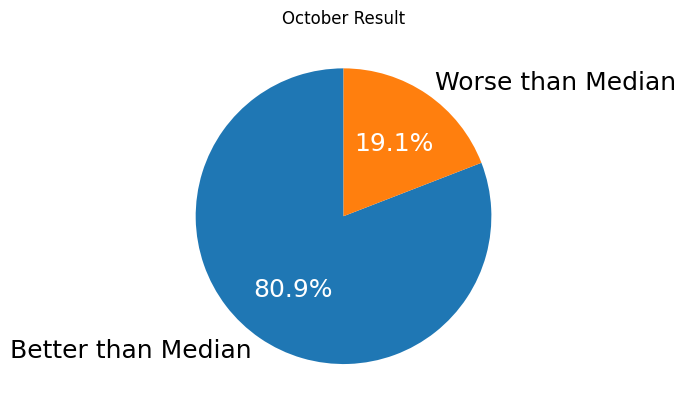

In [14]:
tickers = test
pre_vals = {}
exchanges = ['1', '8', '9', '10', '12', '16', '19', '25', '28', '30']
testing_exchanges = ['8', '9', '10', '12', '16', '19', '25', '28', '30']
input_path = "aggre_csv2/"
path_out1 = "Output1/"
path_out2 = "Output2/"
path_out3 = "Output3/"
best_parameters_path = "Best Patameters.csv"
best_var_path = 'VarParams.csv'

Delete_all_CSV(path_out1)  
Delete_all_CSV(path_out2)   
Delete_all_PNG(path_out3)   
count_better = 0

month = "November" if input_path == "aggre_csv/" else "October"

for ticker in tickers: 
    print("Now Testing:", ticker)
    n_scoring_window = get_best_parameter(best_parameters_path, ticker)
    exchanges_data_df = pd.read_csv(input_path+ticker.replace('/','_')+'.csv',index_col='time')
    exchanges_data_df.index = pd.to_datetime(exchanges_data_df.index)       
    index_prices, start_date = cluster_pricing_tester(ticker,n_scoring_window,True,best_var_path,testing_exchanges,False,input_path)
    [r2, med_r2], [mse, med_mse], [mape, med_mape] = generate_result(ticker, n_scoring_window, index_prices, exchanges_data_df, 10, start_date,month)
    if round(r2, 4) >= round(med_r2, 4):
        count_better += 1 
    print(count_better/len(tickers))

print(month+" Task Complete!")
print("All results have been export to the aimed folders. ")
print("Over", count_better/len(tickers),"of cases are better than median pathes.")

File 

pie, texts, autotexts = plt.pie([count_better, len(tickers)-count_better], labels=["Better than Median", "Worse than Median"], autopct=autopct_format, startangle=90, textprops={'fontsize': 18})

for autotext in autotexts:
    autotext.set_color('white')

plt.title(month + " Result")
plt.show()


<center><img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/></center>